# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

> raw 픽셀로부터 계산된 feature들을 이용하여 linear classifier를 학습 시키면 성능이 향상될 수 있음을 살펴보겠다.

All of your work for this exercise will be done in this notebook.

In [3]:
import os
os.getcwd()
os.chdir('/root/data/pudae/git/cs231n/pudae/assignment1')

In [4]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [5]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

> 각 이미지로부터 HOG와 color histogram을 추출하고, 둘을 연결하여 feature 벡터로 사용하겠다.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

> HOG는 색상 정보를 무시한 이미지 텍스처를 캡쳐, color histogram은 텍스처를 무시하고 컬러 정보를 표현
> 이 둘을 함께 사용하여 더 나은 성능을 내길 기대함

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [53]:
from cs231n.features import *

num_color_bins = 20 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [20]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [1e5, 1e6, 1e7]

results = {}
best_val = -1
best_svm = None

top_n = 10

exp_lr_min = -10
exp_lr_max = -3
exp_rs_min = 2
exp_rs_max = 6

results = {}
for _ in xrange(5):
    for _ in xrange(25):
        exp_lr = np.random.uniform(exp_lr_min, exp_lr_max)
        exp_rs = np.random.uniform(exp_rs_min, exp_rs_max)
        lr = 10 ** exp_lr
        rs = 10 ** exp_rs
            
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, lr, rs, num_iters=1500)
        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)
        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)
        
        results[(exp_lr, exp_rs)] = (val_accuracy, train_accuracy)
        # -print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (lr, rs, train_accuracy, val_accuracy)
        print '.',
        if best_val < val_accuracy:
            best_val = val_accuracy
            best_svm = svm
      
    print
    print '=========================================================================='
    print ' intermediate result: '
    top_n_results = sorted(results, key=results.get, reverse=True)[0:top_n]
    for exp_lr, exp_rs in sorted(top_n_results):
        val_accuracy, train_accuracy = results[(exp_lr, exp_rs)]
        print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (10**exp_lr, 10**exp_rs, train_accuracy, val_accuracy)
        results[(exp_lr, exp_rs)] = (val_accuracy, train_accuracy)
    
    exp_lr_min = min({k[0] for k in top_n_results})
    exp_lr_max = max({k[0] for k in top_n_results})
    exp_rs_min = min({k[1] for k in top_n_results})
    exp_rs_max = max({k[1] for k in top_n_results})
    print 'new exp_lr (%e, %e) new exp_rs (%e, %e)' % (exp_lr_min, exp_lr_max, exp_rs_min, exp_rs_max)

    
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
print '=========================================================================='
print ' result: '

for exp_lr, exp_rs in sorted(results, key=results.get, reverse=True)[0:5]:
    val_accuracy, train_accuracy = results[(exp_lr, exp_rs)]
    print 'train accuracy: %f val accuracy: %f lr %e reg %e ' % (
                train_accuracy, val_accuracy, 10**exp_lr, 10**exp_rs)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

 . . . . . . . . . . . . . . . . . . . . . . . . .
 intermediate result: 
lr 9.821197e-08 reg 3.808785e+05 train accuracy: 0.426633 val accuracy: 0.431000
lr 1.864553e-07 reg 6.085194e+05 train accuracy: 0.418449 val accuracy: 0.408000
lr 6.034609e-07 reg 1.523034e+04 train accuracy: 0.423224 val accuracy: 0.421000
lr 6.508257e-07 reg 8.187594e+03 train accuracy: 0.424714 val accuracy: 0.429000
lr 8.447886e-07 reg 8.114136e+05 train accuracy: 0.349082 val accuracy: 0.349000
lr 1.759769e-06 reg 6.070624e+04 train accuracy: 0.417776 val accuracy: 0.433000
lr 2.241932e-06 reg 6.669702e+04 train accuracy: 0.407000 val accuracy: 0.392000
lr 3.776180e-06 reg 6.158438e+03 train accuracy: 0.421939 val accuracy: 0.423000
lr 4.108873e-06 reg 1.261712e+05 train accuracy: 0.371980 val accuracy: 0.385000
lr 7.531326e-05 reg 6.085719e+02 train accuracy: 0.423327 val accuracy: 0.428000
new exp_lr (-7.007836e+00, -4.123129e+00) new exp_rs (2.784312e+00, 5.909242e+00)
. . . . . . . . . . . . . . . . . 

In [21]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print test_accuracy

0.412


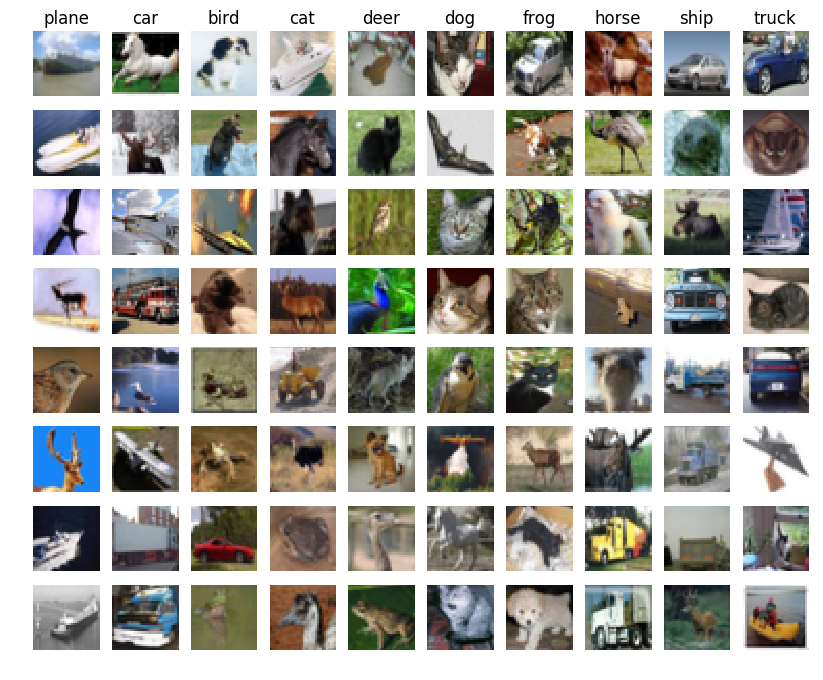

In [54]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

> 잘 모르겠다.
> plane을 보면 색상의 비율(하늘을 표현하는 색의 비율)이 큰 영향을 끼친 것으로 보이기도 하는데, 다른 분류들에서는 확실히 알 수 없었다.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

> image feature를 이용하여 2-layer NN에서 성능 더 끌어올려보기

In [24]:
print X_train_feats.shape

(49000, 175)


In [28]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

best_net = None
"""
################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
for _ in xrange(2):
    lr = np.random.uniform(0.5, 1.0)
    rs = np.random.uniform(0.01, 0.02)
    print 'learning_rates:', lr
    print 'regularization_strengths:', rs
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)

    # Train the network
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                      num_iters=1500, batch_size=200,
                      learning_rate=lr, learning_rate_decay=0.95,
                      reg=rs, verbose=True)
    y_train_pred = net.predict(X_train_feats)
    y_val_pred = net.predict(X_val_feats)
    train_accuracy = np.mean(y_train == y_train_pred)
    val_accuracy = np.mean(y_val == y_val_pred)
    results[(lr, rs)] = (train_accuracy, val_accuracy)
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (lr, rs, train_accuracy, val_accuracy)
    if best_val < val_accuracy:
        best_val = val_accuracy
        best_net = net
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
"""
top_n = 30

exp_lr_min = -4
exp_lr_max = -0.1
exp_rs_min = -3
exp_rs_max = -0.5

results = {}
for _ in xrange(10):
    for _ in xrange(50):
        exp_lr = np.random.uniform(exp_lr_min, exp_lr_max)
        exp_rs = np.random.uniform(exp_rs_min, exp_rs_max)
        lr = 10 ** exp_lr
        rs = 10 ** exp_rs

        net = TwoLayerNet(input_dim, hidden_dim, num_classes)

        # Train the network
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                          num_iters=5000, batch_size=200,
                          learning_rate=lr, learning_rate_decay=0.95,
                          reg=rs, verbose=False)
        y_train_pred = net.predict(X_train_feats)
        y_val_pred = net.predict(X_val_feats)
        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)
        
        results[(exp_lr, exp_rs)] = (val_accuracy, train_accuracy)
        # -print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (lr, rs, train_accuracy, val_accuracy)
        print '.',
    if best_val < val_accuracy:
        best_val = val_accuracy
        best_net = net
      
    print
    print '=========================================================================='
    print ' intermediate result: '
    top_n_results = sorted(results, key=results.get, reverse=True)[0:top_n]
    for exp_lr, exp_rs in sorted(top_n_results):
        val_accuracy, train_accuracy = results[(exp_lr, exp_rs)]
        print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (10**exp_lr, 10**exp_rs, train_accuracy, val_accuracy)
        results[(exp_lr, exp_rs)] = (val_accuracy, train_accuracy)
    
    exp_lr_min = min({k[0] for k in top_n_results})
    exp_lr_max = max({k[0] for k in top_n_results})
    exp_rs_min = min({k[1] for k in top_n_results})
    exp_rs_max = max({k[1] for k in top_n_results})
    print 'new exp_lr (%e, %e) new exp_rs (%e, %e)' % (exp_lr_min, exp_lr_max, exp_rs_min, exp_rs_max)

    
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
print '=========================================================================='
print ' result: '

for exp_lr, exp_rs in sorted(results, key=results.get, reverse=True)[0:5]:
    val_accuracy, train_accuracy = results[(exp_lr, exp_rs)]
    print 'train accuracy: %f val accuracy: %f lr %e reg %e ' % (
                train_accuracy, val_accuracy, 10**exp_lr, 10**exp_rs)
    print 'exp_lr: %f exp_rs: %f' % (exp_lr, exp_rs)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

. . . . . . . . . . . . . . . . . . . . . . . . .
 intermediate result: 
lr 6.185738e-03 reg 2.329533e-03 train accuracy: 0.224776 val accuracy: 0.238000
lr 2.358146e-02 reg 1.434357e-03 train accuracy: 0.517612 val accuracy: 0.521000
lr 2.680022e-02 reg 1.407404e-02 train accuracy: 0.515878 val accuracy: 0.515000
lr 3.269378e-02 reg 2.923764e-03 train accuracy: 0.536286 val accuracy: 0.519000
lr 6.005388e-02 reg 3.745686e-03 train accuracy: 0.564082 val accuracy: 0.552000
lr 7.858439e-02 reg 2.536634e-01 train accuracy: 0.289163 val accuracy: 0.272000
lr 1.309718e-01 reg 1.512158e-02 train accuracy: 0.549367 val accuracy: 0.532000
lr 1.989079e-01 reg 3.301386e-03 train accuracy: 0.677265 val accuracy: 0.623000
lr 2.248477e-01 reg 9.904822e-02 train accuracy: 0.450898 val accuracy: 0.439000
lr 3.678048e-01 reg 1.325377e-01 train accuracy: 0.422857 val accuracy: 0.418000
new exp_lr (-2.208608e+00, -4.343826e-01) new exp_rs (-2.843343e+00, -5.957421e-01)
. . . . . . . . . . . . . . . . .

In [29]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print test_acc

0.588


iteration 0 / 5000: loss 2.302587
iteration 100 / 5000: loss 1.404298
iteration 200 / 5000: loss 1.370760
iteration 300 / 5000: loss 1.403044
iteration 400 / 5000: loss 1.353528
iteration 500 / 5000: loss 1.231284
iteration 600 / 5000: loss 1.237788
iteration 700 / 5000: loss 1.277655
iteration 800 / 5000: loss 1.235330
iteration 900 / 5000: loss 1.310915
iteration 1000 / 5000: loss 1.209987
iteration 1100 / 5000: loss 1.159333
iteration 1200 / 5000: loss 1.292041
iteration 1300 / 5000: loss 1.161443
iteration 1400 / 5000: loss 1.194014
iteration 1500 / 5000: loss 1.243772
iteration 1600 / 5000: loss 1.273235
iteration 1700 / 5000: loss 1.157893
iteration 1800 / 5000: loss 1.245446
iteration 1900 / 5000: loss 1.161776
iteration 2000 / 5000: loss 1.216726
iteration 2100 / 5000: loss 1.134109
iteration 2200 / 5000: loss 1.120539
iteration 2300 / 5000: loss 1.160695
iteration 2400 / 5000: loss 1.135177
iteration 2500 / 5000: loss 1.181608
iteration 2600 / 5000: loss 1.240224
iteration 270

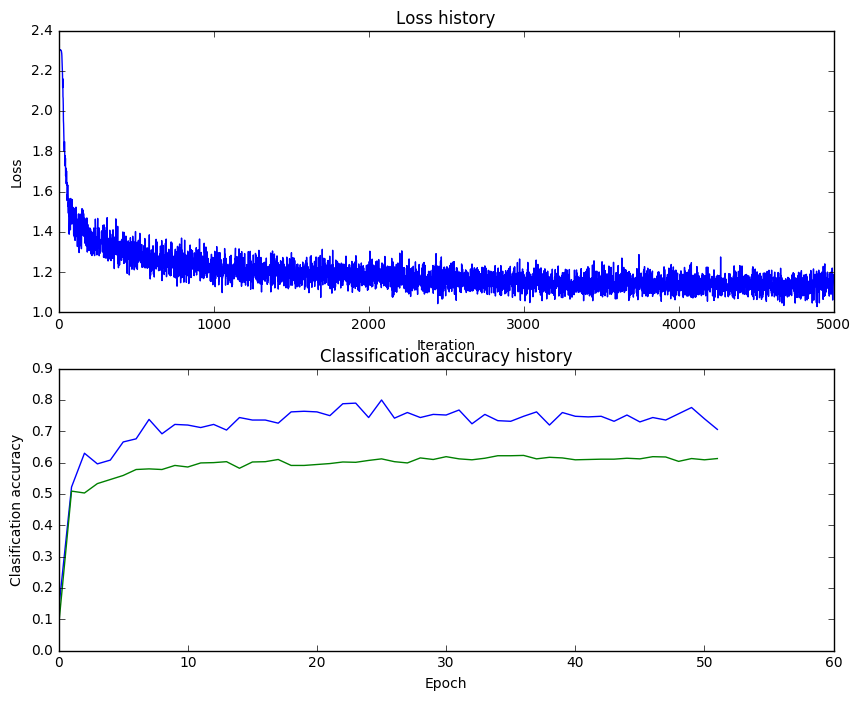

In [48]:
def debug_training(lr, rs):
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)

    # Train the network
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                      num_iters=5000, batch_size=500,
                      learning_rate=lr, learning_rate_decay=0.95,
                      reg=rs, verbose=True)
    y_val_pred = net.predict(X_val_feats)
    val_accuracy = np.mean(y_val == y_val_pred)
    print 'Validation accuracy: ', val_accuracy
    
    # Plot the loss function and train / validation accuracies
    plt.subplot(2, 1, 1)
    plt.plot(stats['loss_history'])
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.subplot(2, 1, 2)
    plt.plot(stats['train_acc_history'], label='train')
    plt.plot(stats['val_acc_history'], label='val')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Clasification accuracy')
    plt.show()
    
    return net
   
net = debug_training(10**-0.101348, 10**-2.381304)

In [50]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print test_acc

0.602


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!